<a href="https://colab.research.google.com/github/Magferat/Clustering-with-Neural-Networks/blob/main/DEC_CSE425.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:


import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
import seaborn as sns
import pandas as pd

In [2]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


100%|██████████| 9.91M/9.91M [00:11<00:00, 896kB/s] 
100%|██████████| 28.9k/28.9k [00:00<00:00, 135kB/s]
100%|██████████| 1.65M/1.65M [00:01<00:00, 1.09MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 6.36MB/s]


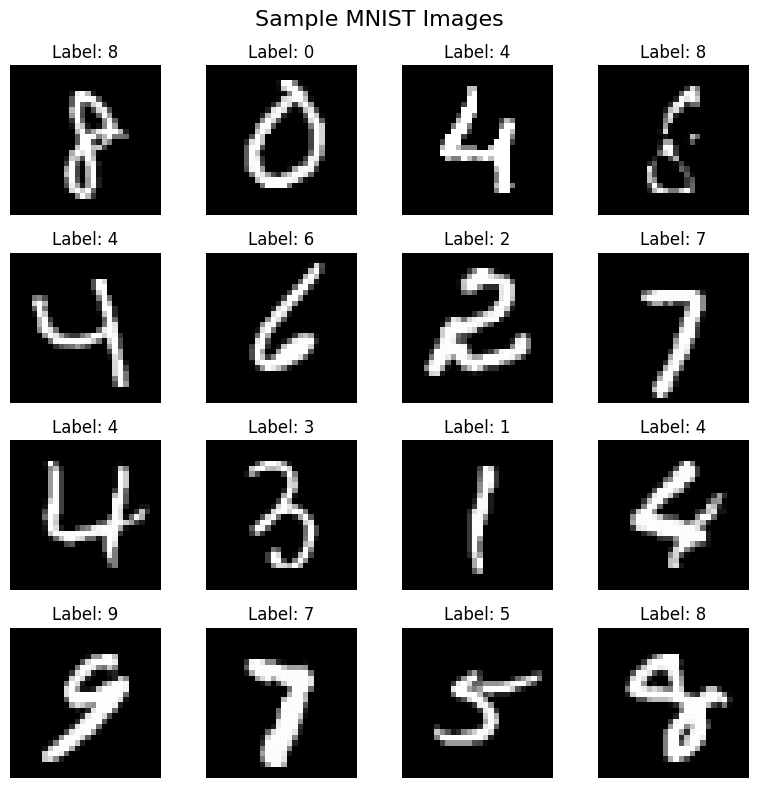

In [3]:


# Get a batch of images
dataiter = iter(train_loader)
images, labels = next(dataiter)

# Plot the first 16 images
plt.figure(figsize=(8, 8))
for i in range(16):
    plt.subplot(4, 4, i+1)
    plt.imshow(images[i].squeeze(), cmap='gray')
    plt.title(f"Label: {labels[i].item()}")
    plt.axis('off')
plt.suptitle("Sample MNIST Images", fontsize=16)
plt.tight_layout()
plt.show()


<ipython-input-4-e5b6255af81d>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x="Digit", data=label_df, palette="viridis")


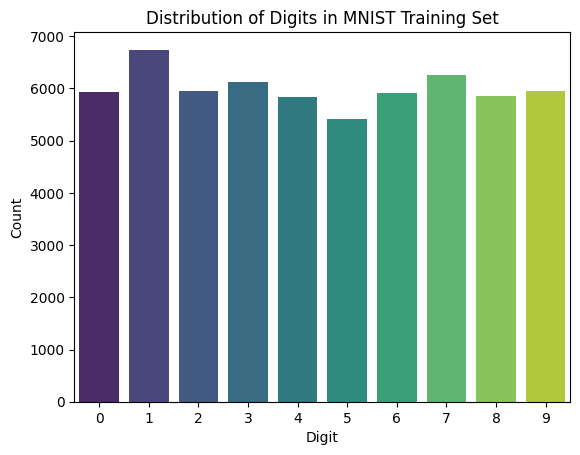

In [4]:


# Collect all labels from the full dataset
all_labels = [label for _, label in train_dataset]

# Create a bar plot of label distribution
label_df = pd.DataFrame(all_labels, columns=["Digit"])
sns.countplot(x="Digit", data=label_df, palette="viridis")
plt.title("Distribution of Digits in MNIST Training Set")
plt.xlabel("Digit")
plt.ylabel("Count")
plt.show()


In [5]:
class Autoencoder(nn.Module):
    def __init__(self, latent_dim=10):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, 3, stride=2, padding=1),  # 14x14
            nn.ReLU(),
            nn.Conv2d(32, 64, 3, stride=2, padding=1), # 7x7
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(64 * 7 * 7, latent_dim)
        )
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 64 * 7 * 7),
            nn.ReLU(),
            nn.Unflatten(1, (64, 7, 7)),
            nn.ConvTranspose2d(64, 32, 3, stride=2, padding=1, output_padding=1), # 14x14
            nn.ReLU(),
            nn.ConvTranspose2d(32, 1, 3, stride=2, padding=1, output_padding=1), # 28x28
            nn.Tanh()
        )

    def forward(self, x):
        z = self.encoder(x)
        x_recon = self.decoder(z)
        return z, x_recon


In [6]:
ae = Autoencoder().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(ae.parameters(), lr=1e-3)

# Pretrain loop
for epoch in range(20):
    epoch_loss = 0
    for imgs, _ in tqdm(train_loader, desc=f"AE Epoch {epoch+1}"):
        imgs = imgs.to(device)
        _, recons = ae(imgs)
        loss = criterion(recons, imgs)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    print(f"Epoch {epoch+1}, Loss: {epoch_loss / len(train_loader):.4f}")


AE Epoch 1: 100%|██████████| 235/235 [00:16<00:00, 14.56it/s]


Epoch 1, Loss: 0.1992


AE Epoch 2: 100%|██████████| 235/235 [00:14<00:00, 15.85it/s]


Epoch 2, Loss: 0.0970


AE Epoch 3: 100%|██████████| 235/235 [00:14<00:00, 15.85it/s]


Epoch 3, Loss: 0.0833


AE Epoch 4: 100%|██████████| 235/235 [00:15<00:00, 15.50it/s]


Epoch 4, Loss: 0.0765


AE Epoch 5: 100%|██████████| 235/235 [00:15<00:00, 15.28it/s]


Epoch 5, Loss: 0.0719


AE Epoch 6: 100%|██████████| 235/235 [00:16<00:00, 14.13it/s]


Epoch 6, Loss: 0.0689


AE Epoch 7: 100%|██████████| 235/235 [00:14<00:00, 15.80it/s]


Epoch 7, Loss: 0.0665


AE Epoch 8: 100%|██████████| 235/235 [00:14<00:00, 15.76it/s]


Epoch 8, Loss: 0.0645


AE Epoch 9: 100%|██████████| 235/235 [00:15<00:00, 15.24it/s]


Epoch 9, Loss: 0.0630


AE Epoch 10: 100%|██████████| 235/235 [00:14<00:00, 15.88it/s]


Epoch 10, Loss: 0.0616


AE Epoch 11: 100%|██████████| 235/235 [00:14<00:00, 15.86it/s]


Epoch 11, Loss: 0.0605


AE Epoch 12: 100%|██████████| 235/235 [00:14<00:00, 15.98it/s]


Epoch 12, Loss: 0.0595


AE Epoch 13: 100%|██████████| 235/235 [00:14<00:00, 15.82it/s]


Epoch 13, Loss: 0.0586


AE Epoch 14: 100%|██████████| 235/235 [00:15<00:00, 15.34it/s]


Epoch 14, Loss: 0.0577


AE Epoch 15: 100%|██████████| 235/235 [00:14<00:00, 15.84it/s]


Epoch 15, Loss: 0.0571


AE Epoch 16: 100%|██████████| 235/235 [00:15<00:00, 14.83it/s]


Epoch 16, Loss: 0.0564


AE Epoch 17: 100%|██████████| 235/235 [00:14<00:00, 15.85it/s]


Epoch 17, Loss: 0.0559


AE Epoch 18: 100%|██████████| 235/235 [00:14<00:00, 15.77it/s]


Epoch 18, Loss: 0.0553


AE Epoch 19: 100%|██████████| 235/235 [00:15<00:00, 15.33it/s]


Epoch 19, Loss: 0.0548


AE Epoch 20: 100%|██████████| 235/235 [00:14<00:00, 15.99it/s]

Epoch 20, Loss: 0.0544


In [7]:
def target_distribution(q):
    weight = q**2 / q.sum(0)
    return (weight.T / weight.sum(1)).T

class DEC:
    def __init__(self, model, n_clusters=10, alpha=1.0):
        self.model = model
        self.n_clusters = n_clusters
        self.alpha = alpha
        self.cluster_centers = nn.Parameter(
            torch.randn(n_clusters, 10, dtype=torch.float32).to(device)
        )

    def soft_assign(self, z):
        z = z.float()
        dist = torch.cdist(z, self.cluster_centers, p=2) ** 2
        num = (1.0 + dist / self.alpha) ** ((self.alpha + 1.0) / -2)
        return (num.T / num.sum(1)).T  # shape: (batch, n_clusters)

    def kl_loss(self, q, p):
        return torch.nn.functional.kl_div(q.log(), p, reduction='batchmean')

# Step 1: Extract embeddings
ae.eval()
all_embeddings = []
all_labels = []

with torch.no_grad():
    for imgs, labels in train_loader:
        imgs = imgs.to(device)
        z, _ = ae(imgs)
        all_embeddings.append(z.cpu())
        all_labels.append(labels)

embeddings = torch.cat(all_embeddings)
labels = torch.cat(all_labels)

# Step 2: Init cluster centers with KMeans
kmeans = KMeans(n_clusters=10, n_init=20)
y_pred = kmeans.fit_predict(embeddings)
dec = DEC(ae, 10)
dec.cluster_centers.data = torch.tensor(
    kmeans.cluster_centers_, dtype=torch.float32, device=device
)

# Step 3: DEC training
optimizer = optim.Adam(
    [{'params': ae.encoder.parameters()}, {'params': dec.cluster_centers}], lr=1e-3
)

for epoch in range(30):
    epoch_loss = 0
    for imgs, _ in tqdm(train_loader, desc=f"DEC Epoch {epoch+1}"):
        imgs = imgs.to(device)
        z, _ = ae(imgs)
        q = dec.soft_assign(z)
        p = target_distribution(q.detach())
        loss = dec.kl_loss(q, p)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    print(f"[DEC] Epoch {epoch+1}, Loss: {epoch_loss / len(train_loader):.4f}")


DEC Epoch 1: 100%|██████████| 235/235 [00:15<00:00, 15.55it/s]


[DEC] Epoch 1, Loss: 0.2184


DEC Epoch 2: 100%|██████████| 235/235 [00:15<00:00, 15.44it/s]


[DEC] Epoch 2, Loss: 0.1912


DEC Epoch 3: 100%|██████████| 235/235 [00:14<00:00, 16.29it/s]


[DEC] Epoch 3, Loss: 0.1787


DEC Epoch 4: 100%|██████████| 235/235 [00:14<00:00, 16.04it/s]


[DEC] Epoch 4, Loss: 0.1709


DEC Epoch 5: 100%|██████████| 235/235 [00:14<00:00, 16.24it/s]


[DEC] Epoch 5, Loss: 0.1646


DEC Epoch 6: 100%|██████████| 235/235 [00:14<00:00, 16.09it/s]


[DEC] Epoch 6, Loss: 0.1599


DEC Epoch 7: 100%|██████████| 235/235 [00:15<00:00, 15.52it/s]


[DEC] Epoch 7, Loss: 0.1559


DEC Epoch 8: 100%|██████████| 235/235 [00:14<00:00, 15.78it/s]


[DEC] Epoch 8, Loss: 0.1519


DEC Epoch 9: 100%|██████████| 235/235 [00:14<00:00, 16.25it/s]


[DEC] Epoch 9, Loss: 0.1489


DEC Epoch 10: 100%|██████████| 235/235 [00:14<00:00, 16.10it/s]


[DEC] Epoch 10, Loss: 0.1459


DEC Epoch 11: 100%|██████████| 235/235 [00:14<00:00, 15.97it/s]


[DEC] Epoch 11, Loss: 0.1431


DEC Epoch 12: 100%|██████████| 235/235 [00:14<00:00, 15.73it/s]


[DEC] Epoch 12, Loss: 0.1408


DEC Epoch 13: 100%|██████████| 235/235 [00:15<00:00, 15.40it/s]


[DEC] Epoch 13, Loss: 0.1381


DEC Epoch 14: 100%|██████████| 235/235 [00:14<00:00, 16.16it/s]


[DEC] Epoch 14, Loss: 0.1362


DEC Epoch 15: 100%|██████████| 235/235 [00:14<00:00, 16.34it/s]


[DEC] Epoch 15, Loss: 0.1343


DEC Epoch 16: 100%|██████████| 235/235 [00:14<00:00, 16.29it/s]


[DEC] Epoch 16, Loss: 0.1322


DEC Epoch 17: 100%|██████████| 235/235 [00:14<00:00, 16.16it/s]


[DEC] Epoch 17, Loss: 0.1306


DEC Epoch 18: 100%|██████████| 235/235 [00:15<00:00, 15.58it/s]


[DEC] Epoch 18, Loss: 0.1295


DEC Epoch 19: 100%|██████████| 235/235 [00:14<00:00, 15.95it/s]


[DEC] Epoch 19, Loss: 0.1274


DEC Epoch 20: 100%|██████████| 235/235 [00:14<00:00, 16.05it/s]


[DEC] Epoch 20, Loss: 0.1259


DEC Epoch 21: 100%|██████████| 235/235 [00:14<00:00, 16.05it/s]


[DEC] Epoch 21, Loss: 0.1247


DEC Epoch 22: 100%|██████████| 235/235 [00:15<00:00, 15.33it/s]


[DEC] Epoch 22, Loss: 0.1233


DEC Epoch 23: 100%|██████████| 235/235 [00:14<00:00, 15.77it/s]


[DEC] Epoch 23, Loss: 0.1215


DEC Epoch 24: 100%|██████████| 235/235 [00:14<00:00, 15.71it/s]


[DEC] Epoch 24, Loss: 0.1206


DEC Epoch 25: 100%|██████████| 235/235 [00:14<00:00, 16.05it/s]


[DEC] Epoch 25, Loss: 0.1195


DEC Epoch 26: 100%|██████████| 235/235 [00:14<00:00, 16.28it/s]


[DEC] Epoch 26, Loss: 0.1182


DEC Epoch 27: 100%|██████████| 235/235 [00:14<00:00, 16.23it/s]


[DEC] Epoch 27, Loss: 0.1170


DEC Epoch 28: 100%|██████████| 235/235 [00:14<00:00, 16.18it/s]


[DEC] Epoch 28, Loss: 0.1159


DEC Epoch 29: 100%|██████████| 235/235 [00:15<00:00, 15.29it/s]


[DEC] Epoch 29, Loss: 0.1147


DEC Epoch 30: 100%|██████████| 235/235 [00:14<00:00, 16.17it/s]

[DEC] Epoch 30, Loss: 0.1139


In [8]:

ae.eval()
with torch.no_grad():
    all_z = []
    for imgs, _ in train_loader:
        z, _ = ae(imgs.to(device))
        all_z.append(z.cpu())
    z = torch.cat(all_z).numpy()

# KMeans clustering
kmeans = KMeans(n_clusters=10, n_init=20).fit(z)
labels_pred = kmeans.labels_

# Evaluation metrics
sil = silhouette_score(z, labels_pred)
db = davies_bouldin_score(z, labels_pred)
chi = calinski_harabasz_score(z, labels_pred)

print(f"Silhouette Score:         {sil:.4f}")
print(f"Davies-Bouldin Index:     {db:.4f}")
print(f"Calinski-Harabasz Index:  {chi:.4f}")


Silhouette Score:         0.7392
Davies-Bouldin Index:     0.3360
Calinski-Harabasz Index:  154676.8594


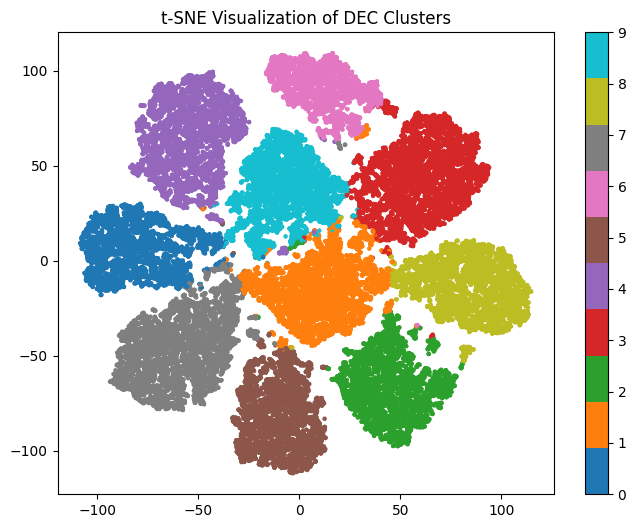

In [9]:
tsne = TSNE(n_components=2, random_state=42)
z_2d = tsne.fit_transform(z)

plt.figure(figsize=(8,6))
plt.scatter(z_2d[:, 0], z_2d[:, 1], c=kmeans.labels_, cmap='tab10', s=5)
plt.title("t-SNE Visualization of DEC Clusters")
plt.colorbar()
plt.show()


In [10]:
import pickle

with open("dec_results.pkl", "wb") as f:
    pickle.dump({
        "embeddings": z,
        "labels": labels.numpy(),
        "preds": kmeans.labels_,
        "silhouette": sil,
        "db_score": db
    }, f)
torch.save(ae.state_dict(), "autoencoder_mnist.pth")
